# Segmentation of Indian Traffic

In [52]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib

<pre>
1. You can download the data from this link (https://idd.insaan.iiit.ac.in/)  ,and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [75]:
path = 'data'
G = []
for i in os.listdir(path):
    lst = []
    path1 = os.path.join(path, i)
    print(path1)
    for j in os.listdir(path1):
        path2 = os.path.join(path1, j)
        for k in os.listdir(path2):
            path3 = os.path.join(path2, k)
            lst.append(path3)
    G.append(lst)  

data\images
data\mask


In [76]:
data = pd.DataFrame(list(zip(G[0], G[1])), columns = ['images', 'json'])
data.head()

images  \
0  data\images\201\frame0029_leftImg8bit.jpg   
1  data\images\201\frame0299_leftImg8bit.jpg   
2  data\images\201\frame0779_leftImg8bit.jpg   
3  data\images\201\frame1019_leftImg8bit.jpg   
4  data\images\201\frame1469_leftImg8bit.jpg   

                                           json  
0  data\mask\201\frame0029_gtFine_polygons.json  
1  data\mask\201\frame0299_gtFine_polygons.json  
2  data\mask\201\frame0779_gtFine_polygons.json  
3  data\mask\201\frame1019_gtFine_polygons.json  
4  data\mask\201\frame1469_gtFine_polygons.json

In [77]:
import os.path as path
import os
import pandas as pd

def return_file_names_df(root_dir):
    pathlist=[]
    for d in os.listdir(root_dir):
        lst = []
        pa1 = os.path.join(root_dir, d)
        print(pa1)
        for j in os.listdir(pa1):
            pa2 = os.path.join(pa1, j)
            for k in os.listdir(pa2):
                pa3 = os.path.join(pa2, k)
                lst.append(pa3)
        pathlist.append(lst)
    data_df = pd.DataFrame(list(zip(pathlist[0], pathlist[1])), columns = ['images', 'json'])
    data_df['images'] = data_df['images'].replace(r'\\', '/', regex=True)
    data_df['json'] = data_df['json'].replace(r'\\', '/', regex=True)

    return data_df




In [ ]:
data_df = return_file_names_df('data')

> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [8]:

def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [9]:
grader_1(data_df)

True

In [10]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [22]:
import json
def return_unique_labels(data_df):
    unique_labels = set()
    for json_file in data_df['json']:
        with open(json_file) as f:
            json_data = json.load(f)
            objects = json_data['objects']
            for obj in objects:
                unique_labels.add(obj['label'])
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    return unique_labels

In [23]:
unique_labels = return_unique_labels(data_df)

In [24]:
len(unique_labels)

40

In [ ]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [25]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [26]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
*here we have given a number for each of object types, if you see we are having 21 different set of objects
*Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
*Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [30]:
import json
  # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
def get_poly(file):
    with open(file) as f:
        data = json.load(f)
    
    w, h = data['imgWidth'], data['imgHeight']
    
    labels = []
    vertexlist = []
    
  
    for obj in data['objects']:
        # get the label of the object
        label = obj['label']
        
        # get the vertices of the polygon
        polygon = obj['polygon']
        vertices_list1 = [(p[0], p[1]) for p in polygon]
        
        # append the label and vertices to the lists
        labels.append(label)
        vertexlist.append(vertices_list1)
    
    return w, h, labels, vertexlist


In [31]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

In [27]:
import numpy as np

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

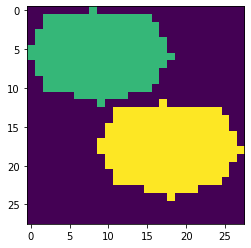

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [34]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygon in the image like this
    for ii,row in data_df.iterrows():
        w,h,label,vertexlist=get_poly(row['json'])
        img = Image.new("RGB", (w, h))
        img1 = ImageDraw.Draw(img)
        for i in range(len(label)):
            if len(vertexlist[i]) >= 1:
                img1.polygon(vertexlist[i], fill = label_clr[label[i]])
        
        # after drawing all the polygons that we collected from json file, 
        # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
        filename = os.path.basename(row['json'])
        frame_number = filename.split("_")[0][:]
        
        output_dir = "data/output/scene"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        mask_path = os.path.join(output_dir, "{}_gtFine_polygons.png".format(frame_number))
        img.save(mask_path)
        data_df.at[ii,'mask']=mask_path
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    
    return data_df


In [ ]:
data_df['mask'] = ""
data_df = compute_masks(data_df)
data_df.head()

In [47]:
data_df['mask'] = data_df['mask'].apply(lambda x: x.replace('\\', '/'))
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
data_df

images  \
0       data/images/201/frame0029_leftImg8bit.jpg   
1       data/images/201/frame0299_leftImg8bit.jpg   
2       data/images/201/frame0779_leftImg8bit.jpg   
3       data/images/201/frame1019_leftImg8bit.jpg   
4       data/images/201/frame1469_leftImg8bit.jpg   
5       data/images/201/frame1979_leftImg8bit.jpg   
6       data/images/201/frame2519_leftImg8bit.jpg   
7       data/images/201/frame2819_leftImg8bit.jpg   
8       data/images/201/frame3179_leftImg8bit.jpg   
9       data/images/201/frame3749_leftImg8bit.jpg   
10      data/images/201/frame4079_leftImg8bit.jpg   
11      data/images/202/frame0018_leftImg8bit.jpg   
12      data/images/202/frame0389_leftImg8bit.jpg   
13      data/images/203/frame0165_leftImg8bit.jpg   
14      data/images/203/frame0435_leftImg8bit.jpg   
15      data/images/203/frame0525_leftImg8bit.jpg   
16      data/images/203/frame0630_leftImg8bit.jpg   
17      data/images/203/frame0675_leftImg8bit.jpg   
18      data/images/203/frame0945_leftImg8bit.jpg   
19      data/images/203/frame1012_leftImg8bit.jpg   
20      data/images/203/frame1185_leftImg8bit.jpg   
21      data/images/203/frame1222_leftImg8bit.jpg   
22      data/images/203/frame1252_leftImg8bit.jpg   
23      data/images/203/frame1394_leftImg8bit.jpg   
24      data/images/203/frame1517_leftImg8bit.jpg   
25      data/images/203/frame1777_leftImg8bit.jpg   
26      data/images/203/frame1885_leftImg8bit.jpg   
27      data/images/203/frame1975_leftImg8bit.jpg   
28      data/images/203/frame2230_leftImg8bit.jpg   
29      data/images/203/frame2305_leftImg8bit.jpg   
30      data/images/203/frame2410_leftImg8bit.jpg   
31      data/images/203/frame2530_leftImg8bit.jpg   
32      data/images/203/frame2605_leftImg8bit.jpg   
33      data/images/203/frame2680_leftImg8bit.jpg   
34      data/images/203/frame2909_leftImg8bit.jpg   
35      data/images/203/frame3239_leftImg8bit.jpg   
36      data/images/203/frame3299_leftImg8bit.jpg   
37      data/images/204/frame0066_leftImg8bit.jpg   
38      data/images/204/frame0221_leftImg8bit.jpg   
39      data/images/204/frame0397_leftImg8bit.jpg   
40      data/images/204/frame0611_leftImg8bit.jpg   
41      data/images/204/frame0791_leftImg8bit.jpg   
42      data/images/204/frame1011_leftImg8bit.jpg   
43     data/images/204/frame10164_leftImg8bit.jpg   
44     data/images/204/frame10355_leftImg8bit.jpg   
45     data/images/204/frame10437_leftImg8bit.jpg   
46     data/images/204/frame10573_leftImg8bit.jpg   
47     data/images/204/frame10764_leftImg8bit.jpg   
48     data/images/204/frame10873_leftImg8bit.jpg   
49     data/images/204/frame10982_leftImg8bit.jpg   
50     data/images/204/frame11119_leftImg8bit.jpg   
51     data/images/204/frame11282_leftImg8bit.jpg   
52     data/images/204/frame11419_leftImg8bit.jpg   
53     data/images/204/frame11528_leftImg8bit.jpg   
54     data/images/204/frame11637_leftImg8bit.jpg   
55     data/images/204/frame11800_leftImg8bit.jpg   
56     data/images/204/frame11964_leftImg8bit.jpg   
57     data/images/204/frame12073_leftImg8bit.jpg   
58     data/images/204/frame12182_leftImg8bit.jpg   
59      data/images/204/frame1221_leftImg8bit.jpg   
60     data/images/204/frame12428_leftImg8bit.jpg   
61     data/images/204/frame12591_leftImg8bit.jpg   
62     data/images/204/frame12891_leftImg8bit.jpg   
63     data/images/204/frame13191_leftImg8bit.jpg   
64     data/images/204/frame13437_leftImg8bit.jpg   
65     data/images/204/frame13600_leftImg8bit.jpg   
66     data/images/204/frame13819_leftImg8bit.jpg   
67     data/images/204/frame13900_leftImg8bit.jpg   
68     data/images/204/frame14173_leftImg8bit.jpg   
69     data/images/204/frame14337_leftImg8bit.jpg   
70     data/images/204/frame14473_leftImg8bit.jpg   
71     data/images/204/frame14582_leftImg8bit.jpg   
72     data/images/204/frame14746_leftImg8bit.jpg   
73     data/images/204/frame14828_leftImg8bit.jpg   
74      data/images/204/frame1491_leftImg8bit.jpg   
75     data/ima

In [47]:
data_df.to_csv('preprocessed_data.csv', index=False)


In [3]:
import pandas as pd
data_df=pd.read_csv('preprocessed_data.csv')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


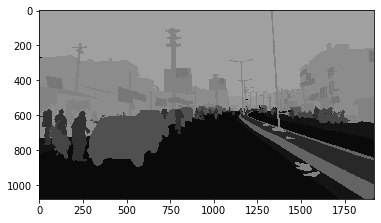

In [51]:
my_img = cv2.imread('data/output/scene/frame0029_gtFine_polygons.png')    
plt.imshow(my_img)

In [4]:
%cd "/content/drive/My Drive/COMPUTER VISION SEGMENTATION/"

/content/drive/My Drive/COMPUTER VISION SEGMENTATION


In [ ]:
!ls 

'Copy of Reference_Pipelines.ipynb'   Reference_Preptrained_Unet.ipynb
 data				     'Segmentation_Assignment (1).ipynb'
 data.zip			      Segmentation_Assignment.ipynb
 preprocessed_data.csv


In [56]:
import tensorflow as tf
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [66]:
# import tensorflow as tf
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

In [61]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten,LSTM, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model
import random as rn

In [62]:
from tensorflow.keras.layers import Flatten

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load image
image = cv2.imread("data/images/201/frame0299_leftImg8bit.jpg")

# Check if image is not None
if image is not None:
    # Print shape
    print(image.shape)

    # Display image
    cv2_imshow(image)
else:
    print('Error: could not read image file')


Output hidden; open in https://colab.research.google.com to view.

In [63]:
%env SM_FRAMEWORK=tf.keras
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

env: SM_FRAMEWORK=tf.keras


C:\Anaconda3\lib\site-packages\classification_models\resnext\__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [65]:
# We are importing the pretrained unet from the segmentation models.
# https://github.com/qubvel/segmentation_models
tf.keras.backend.clear_session()
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.metrics import iou_score
#sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')
#from tensorflow.keras.applications.resnet import preprocess_input

# loading the unet model and using the resnet 50 and initialized weights with Imagenet weights.
# "classes" :different types of classes in the dataset.
#backbone = 'resnet50'
#preprocess_input = sm.get_preprocessing(backbone)

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

### Dice loss:

#### Dice loss is a loss function used in image segmentation task.It measures the similarity between the predicted segmentation mask and the ground truth mask.Dice loss measure the overlap between two sets and the range of dice loss is 0 to 1.

### Formula:
#### Dice coefficient =2*intersection/union+intersection=2TP/2TP+FN+FP
Dice Loss=1-Dice Coefficent 

### Range:
#### The range of the Dice loss function is between 0 and 1.When the predicted msk perfectly matches the ground truth mask,then loss is 0 If the predicted mask has no overlap with the ground truth mask,the Dice loss is 1

### Interpretation:
#### When the Predicted mask does match the ground truth mask the intersection is large and the union is small it means low dice loss and when the predicted mask does not match the ground truth mask,the intersection is small and union is large,resulting in a high dice loss.

### Understanding:
#### The main goal of Image segmentaion is to create the object mask and mask should be very similar to object for better image segmentaion but if mask is not completly overlap with object then with help of dice loss we can find an error.
#### Dice loss match the ground truth with predicted mask to calculate the loss and Dice loss is more robust to class imbalance and can help the model focus on accurately segmenting the object of interest.

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [41]:
backbone = 'resnet34'
preprocess_input = sm.get_preprocessing(backbone)

In [67]:
# import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [68]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
'''def normalize_image(mask):
    mask = mask/255
    return mask'''

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, file_names,classes = None):
        
        self.ids = file_names
        # the paths of images
        self.images_fps   = [image_id for image_id in self.ids['images']]
        # the paths of segmentation images
        self.masks_fps    = [image_id for image_id in self.ids['mask']]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (256, 256),  interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocess_input(image)

        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (256,256),  interpolation = cv2.INTER_NEAREST) #AREA
        mask = mask / 10
        #print(mask.shape)
        #mask = mask[..., 0]

        #image_mask = normalize_image(mask)

        
        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
        #print(image_mask.shape)

        #print(image_mask.shape)
   
        a = np.random.uniform()
        if a<0.2:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.4:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        elif a<0.8:
            image = aug5.augment_image(image)
            image_mask = image_mask
        else:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)
        #print(image.shape)
        #print(image_mask.shape)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [69]:
CLASSES=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
n_cl=len(CLASSES)
BATCH_SIZE = 32
IMAGE_SHAPE = (256, 256, 3)


In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_df, test_size=0.11, random_state=42)
X_train.shape


(3567, 3)

In [ ]:
import os

# Get current working directory
print(os.getcwd())


/content/drive/My Drive/COMPUTER VISION SEGMENTATION


In [58]:
# Dataset for train images
#CLASSES = ['edited']
train_dataset = Dataset(X_train, classes=CLASSES)
test_dataset  = Dataset(X_test, classes=CLASSES)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
print(test_dataloader[0][0].shape)

(32, 256, 256, 3)


In [62]:
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_cl)
#min
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2),
]
     


In [ ]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
model = Unet('resnet34', encoder_weights='imagenet', classes=n_cl, activation='softmax',input_shape =IMAGE_SHAPE)

In [65]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

optim = tf.keras.optimizers.Adam(0.0001)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim, focal_loss, metrics=[iou_score])

In [ ]:
hist = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=20,validation_data=test_dataloader,callbacks=callbacks)

Epoch 1/20
106/106 [==============================] - 389s 4s/step - loss: 0.8545 - iou_score: 0.1542 - val_loss: 1.0293 - val_iou_score: 0.0702
Epoch 2/20
106/106 [==============================] - 388s 4s/step - loss: 0.7004 - iou_score: 0.2643 - val_loss: 0.8346 - val_iou_score: 0.1612
Epoch 3/20
106/106 [==============================] - 387s 4s/step - loss: 0.6417 - iou_score: 0.3101 - val_loss: 0.7836 - val_iou_score: 0.2084
Epoch 4/20
106/106 [==============================] - 386s 4s/step - loss: 0.6021 - iou_score: 0.3405 - val_loss: 0.6606 - val_iou_score: 0.2863
Epoch 5/20
106/106 [==============================] - 385s 4s/step - loss: 0.5754 - iou_score: 0.3631 - val_loss: 0.6421 - val_iou_score: 0.3003
Epoch 6/20
106/106 [==============================] - 383s 4s/step - loss: 0.5630 - iou_score: 0.3725 - val_loss: 0.6485 - val_iou_score: 0.2942
Epoch 7/20
106/106 [==============================] - 383s 4s/step - loss: 0.5396 - iou_score: 0.3945 - val_loss: 0.6174 - val_iou

In [ ]:
his = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=20,validation_data=test_dataloader,callbacks=callbacks)

Epoch 1/20
106/106 [==============================] - 386s 4s/step - loss: 0.5340 - iou_score: 0.4001 - val_loss: 0.5910 - val_iou_score: 0.3409
Epoch 2/20
106/106 [==============================] - 382s 4s/step - loss: 0.5127 - iou_score: 0.4199 - val_loss: 0.6216 - val_iou_score: 0.3183
Epoch 3/20
106/106 [==============================] - 381s 4s/step - loss: 0.5073 - iou_score: 0.4256 - val_loss: 0.5844 - val_iou_score: 0.3507
Epoch 4/20
106/106 [==============================] - 383s 4s/step - loss: 0.4047 - iou_score: 0.5294 - val_loss: 0.4873 - val_iou_score: 0.4400
Epoch 5/20
106/106 [==============================] - 384s 4s/step - loss: 0.3302 - iou_score: 0.6032 - val_loss: 0.3976 - val_iou_score: 0.5359
Epoch 6/20
106/106 [==============================] - 384s 4s/step - loss: 0.3026 - iou_score: 0.6322 - val_loss: 0.4283 - val_iou_score: 0.5165
Epoch 7/20
106/106 [==============================] - 384s 4s/step - loss: 0.3013 - iou_score: 0.6321 - val_loss: 0.3672 - val_iou

In [ ]:
images_ = X_test['images'].values
masks_ = X_test['mask'].values
lst = np.arange(len(images_))

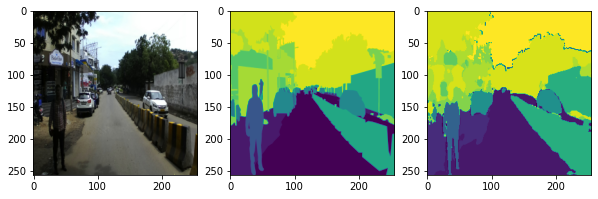

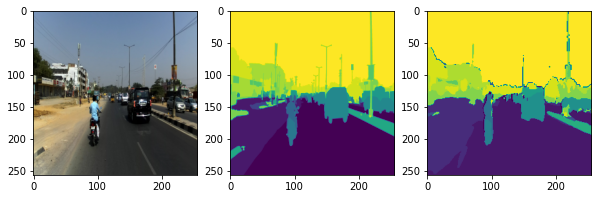

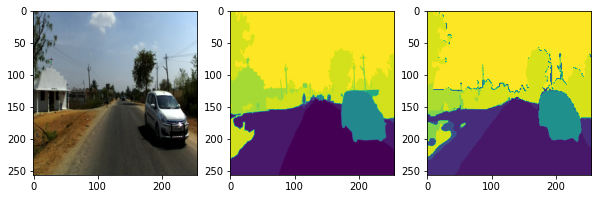

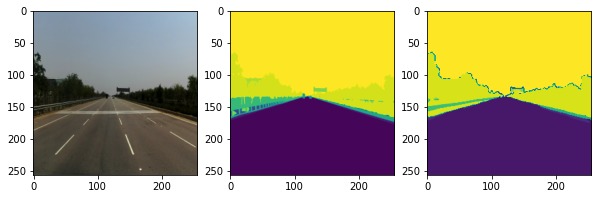

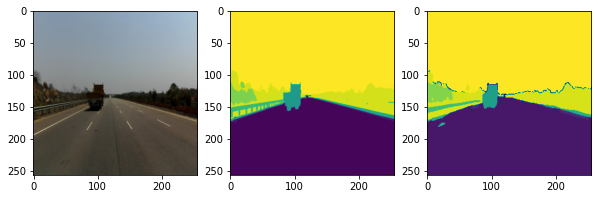

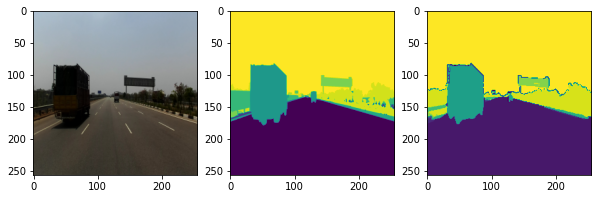

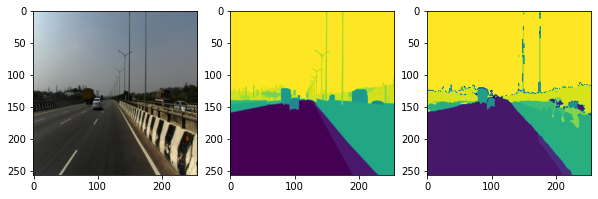

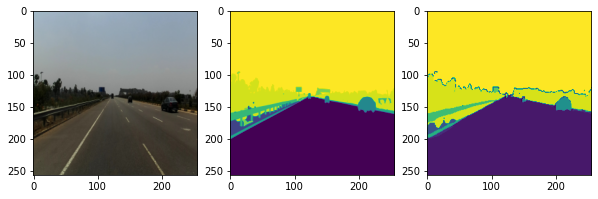

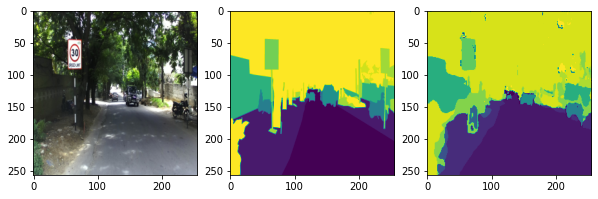

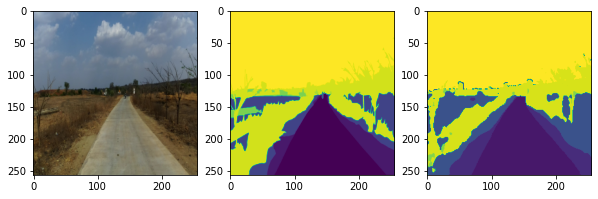

In [ ]:

import random
ids = np.random.choice(lst, size = 15, replace = False)
for i in ids:
    image = cv2.imread(images_[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256, 256),  interpolation = cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, axis=0)

    mask  = cv2.imread(masks_[i], cv2.IMREAD_UNCHANGED)
    mask = cv2.resize(mask, (256, 256),  interpolation = cv2.INTER_AREA)
    mask = mask / 10
    pred = model.predict(image,verbose=1)
    pred = tf.argmax(pred, axis=-1)

    fig = plt.figure(figsize=(10,6))
  #plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(131)
    ax1.imshow(image[0,:,:])
    ax2=fig.add_subplot(132)
    ax2.imshow(mask)
    ax3=fig.add_subplot(133)
    ax3.imshow(pred[0,:,:])
    ax1.title.set_text('Image')
    ax2.title.set_text('Original Mask')
    ax3.title.set_text('Predicted Mask')
    plt.show()

# Task 3: Training CANet

In [4]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [18]:
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, BatchNormalization, Activation, Multiply, UpSampling2D, Add, Concatenate, AveragePooling2D, ReLU
from tensorflow.keras.activations import sigmoid


In [5]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3, filters=[4,4,8], stride=2, name="conv block"):
        super(convolutional_block, self).__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        
        self.conv1 =  Conv2D(self.F1, kernel_size=(1,1), strides=(self.stride,self.stride), name="conv1")
        self.bn1 =  BatchNormalization(name="bn1")
        self.act1 =  Activation('relu', name="act1")
        
        self.conv2 = Conv2D(self.F2, kernel_size=(self.kernel,self.kernel), padding='same', name="conv2")
        self.bn2 =  BatchNormalization(name="bn2")
        self.act2 =  Activation('relu', name="act2")
        
        self.conv3 = Conv2D(self.F3, kernel_size=(1,1), name="conv3")
        self.bn3 =  BatchNormalization(name="bn3")
        
        self.parallel_conv = Conv2D(self.F3, kernel_size=(self.kernel,self.kernel), strides=(self.stride,self.stride), padding='same', name="parallel_conv")
        self.bn4 = BatchNormalization(name="bn4")
        self.act3 = Activation('relu', name="act3")
        
        self.add = Add()
        self.act4 = Activation('relu', name="act4")
        
    def call(self, inputs):
        # conv1
        conv1 = self.conv1(inputs)
        bn1 = self.bn1(conv1)
        act1 = self.act1(bn1)
        
        # conv2
        conv2 = self.conv2(act1)
        bn2 = self.bn2(conv2)
        act2 = self.act2(bn2)
        
        # conv3
        conv3 = self.conv3(act2)
        bn3 = self.bn3(conv3)
        
        # parallel_conv
        parallel_conv = self.parallel_conv(inputs)
        bn4 = self.bn4(parallel_conv)
        act3 = self.act3(bn4)
        
        # element-wise sum
        ele_sum = self.add([act3, bn3])
        
        # final activation
        X = self.act4(ele_sum)
        
        return X


In [6]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3, filters=[4,4,8], stride=2, name="identity block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        
        self.conv1 = tf.keras.layers.Conv2D(self.F1, kernel_size=(1,1), strides=(self.stride, self.stride), padding='valid')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.act1 = tf.keras.layers.Activation('relu')
        
        self.conv2 = tf.keras.layers.Conv2D(self.F2, kernel_size=(self.kernel,self.kernel), strides=(1,1), padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.act2 = tf.keras.layers.Activation('relu')
        
        self.conv3 = tf.keras.layers.Conv2D(self.F3, kernel_size=(1,1), strides=(1,1), padding='valid')
        self.bn3 = tf.keras.layers.BatchNormalization()
        
        self.add = tf.keras.layers.Add()
        self.act3 = tf.keras.layers.Activation('relu')
        
    def call(self, X):
        # save input value for the element-wise sum
        X_shortcut = X

        # 1st component of main path
        X = self.conv1(X)
        X = self.bn1(X)
        X = self.act1(X)

        # 2nd component of main path
        X = self.conv2(X)
        X = self.bn2(X)
        X = self.act2(X)

        # 3rd component of main path
        X = self.conv3(X)
        X = self.bn3(X)

        # add shortcut value to main path, and pass through activation
        X = self.add([X, X_shortcut])
        X = self.act3(X)

        return X


* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [7]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
        self.global_avg_pool = GlobalAveragePooling2D()
        self.bn = BatchNormalization()
        self.conv1 = Conv2D(filters=64, kernel_size=1, strides=1, padding="same")
        self.relu = ReLU()
        self.upsample = UpSampling2D(size=(32, 32), interpolation="bilinear")

    def call(self, X):
        # Apply global average pooling
        X = self.global_avg_pool(X)

        # Reshape the output to have shape (batch_size, 1, 1, channels)
        X = tf.reshape(X, shape=(-1, 1, 1, X.shape[-1]))

        # Apply batch normalization and ReLU activation
        X = self.bn(X)
        X = self.relu(X)

        # Apply a 1x1 convolution with 64 filters
        X = self.conv1(X)

        # Apply upsampling with bilinear interpolation to upsample the feature map
        X = self.upsample(X)

        return X


In [26]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
        self.concat = Concatenate()
        self.avg_pool = AveragePooling2D(pool_size=(2, 2))
        self.conv1 = Conv2D(64,kernel_size=(3,3),padding='same')
        self.conv2 = Conv2D(64,kernel_size=(3,3),padding='same')
        self.conv3 = Conv2D(64,kernel_size=(1,1),padding='same')
        self.conv4= Conv2D(64,kernel_size=(1,1),padding='same')
        self.act_relu = Activation('relu')
        self.act_sigmoid = Activation('sigmoid')
        self.upsample = UpSampling2D(size=(2,2),interpolation='bilinear')
        self.add = Add()
        self.multiply =Multiply()

    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        # implement the context flow as mentioned in the above cell
        concat1 = self.concat([INP,FLOW])
        avg1 = self.avg_pool(concat1)
        conv_1 = self.conv1(avg1)
        conv_2 = self.conv2(conv_1)

        # side path
        conv_3 = self.conv3(conv_2)
        act1   = self.act_relu(conv_3)
        conv_4 = self.conv4(act1)
        act2 = self.act_sigmoid(conv_4)

        # element wise sum

        mul1= self.multiply([conv_2,act2])
        sum2 = self.add([conv_2,mul1])

        X= self.upsample(sum2)

        return X

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [32]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        self.conv_1 = Conv2D(32 ,kernel_size=(3,3),padding='same')
        self.global_avg_pool = GlobalAveragePooling2D()
        self.conv_2 = Conv2D(32 ,kernel_size=(1,1),padding='same')
        self.bn =BatchNormalization()
        self.act_sigmoid= Activation('sigmoid')
        self.multiply =Multiply()
        self.upsample = UpSampling2D(size=(2,2),interpolation='bilinear')
        
    def call(self, X):
        # implement the FSM modules based on image in the above cells
        X= self.conv_1(X)
        avg = self.global_avg_pool(X)
        avg= tf.expand_dims(global_avg, 1)
        avg = tf.expand_dims(global_avg, 1)
        conv1= self.conv_2(avg)
        bn1= self.bn(conv1)
        Y = self.act_sigmoid(bn1)
        output = self.multiply([X, Y])
        FSM_Conv_T = self.upsample(output)

        return FSM_Conv_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [31]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        self.con1  = Conv2D(32,kernel_size=(1,7),padding='same')
        self.con2  = Conv2D(32,kernel_size=(7,1),padding='same')
        self.con3  = Conv2D(32,kernel_size=(1,7),padding='same')
        self.con4  = Conv2D(32,kernel_size=(7,1),padding='same')
        self.con3  = Conv2D(32,kernel_size=(3,3),padding='same')
        self.add = Add()
        
    def call(self, X):
        # please implement the above mentioned architecture
        c1 = self.con1(X)
        conv2= self.con2(c1)

        # side path
        conv3 = self.con4(X)
        conv4 = self.con3(conv3)

        add1 = self.add([conv2,conv4])

        conv5 = self.con3(add1)

        X = self.add([conv5,add1])

        return X

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [29]:
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, BatchNormalization, Activation, Multiply, UpSampling2D, Add, Concatenate, AveragePooling2D, ReLU
from tensorflow.keras.activations import sigmoid


In [ ]:
X_input = Input(shape=(256,256,3))
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

In [35]:

X = convolutional_block(kernel=3,filters=[4,4,8],stride= 2,name  = 'conv_block1')(X)
X_CC1 = X
X = identity_block(kernel = 3,filters=[4,4,8],stride=1,name='identity_block11')(X)

X = convolutional_block(kernel=3,filters=[8,8,16],stride= 2,name  = 'conv_block2')(X)
X = identity_block(kernel = 3,filters=[8,8,16],stride=1,name='identity_block21')(X)
X = identity_block(kernel = 3,filters=[8,8,16],stride=1,name='identity_block22')(X)

X = convolutional_block(kernel=3,filters=[16,16,32],stride= 1,name  = 'conv_block3')(X)
X = identity_block(kernel = 3,filters=[16,16,32],stride=1,name='identity_block31')(X)
X = identity_block(kernel = 3,filters=[16,16,32],stride=1,name='identity_block32')(X)
X = identity_block(kernel = 3,filters=[16,16,32],stride=1,name='identity_block33')(X)


X = convolutional_block(kernel=3,filters=[32,32,64],stride= 1,name  = 'conv_block4')(X)
X = identity_block(kernel = 3,filters=[32,32,64],stride=1,name='identity_block41')(X)
X = identity_block(kernel = 3,filters=[32,32,64],stride=1,name='identity_block42')(X)
X = identity_block(kernel = 3,filters=[32,32,64],stride=1,name='identity_block43')(X)
X_id4 = identity_block(kernel = 3,filters=[32,32,64],stride=1,name='identity_block44')(X)



X = global_flow(name = 'global_flow')(X_id4)
X_GF = X
X_Ccff1 = context_flow(name='context_flow1')([X_id4,X_GF])
X_Ccff2 = context_flow(name='context_flow2')([X_id4,X_Ccff1])
X_CF3 = context_flow(name='context_flow3')([X_id4,X_Ccff2])
added = add([X,X_Ccff1,X_Ccff2,X_CF3])
X_FSM = fsm(name='fsm_stage')(added)
X_agcn = agcn(name='agcn')(X_CC1)
concat = Concatenate()([X_FSM,X_agcn])


Final1 = Conv2D(21, (3, 3), activation = 'relu', padding = 'same', name = 'FinalBlock1')(concat)

o_Final  = UpSampling2D((4,4), interpolation = 'bilinear')(Final1)

Final = (Activation('softmax'))(o_Final)



In [ ]:
model = Model(inputs = X_input, outputs = Final, name='ResNet50')

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [36]:

model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_227 (Activation)     (None, 256, 256, 64) 0           bn_conv1[0][0]                   
___________________________________________________________________________________________

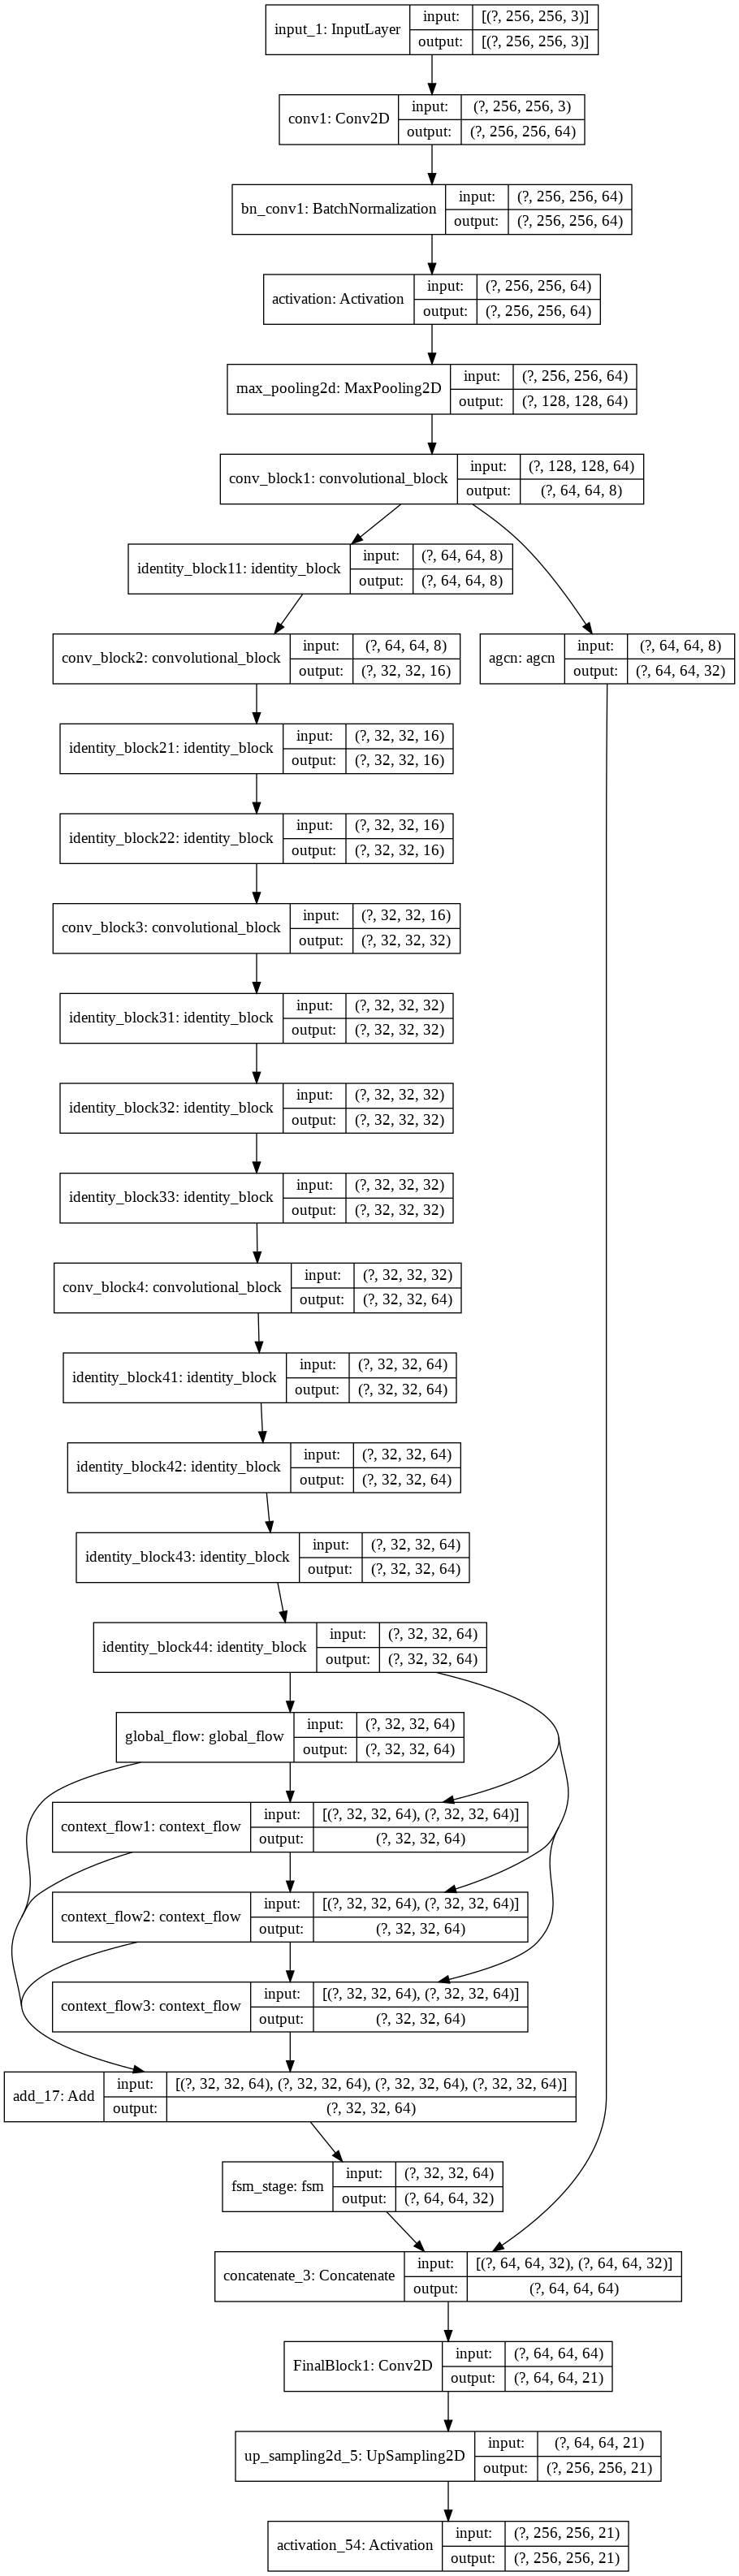

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [39]:
#https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

Using TensorFlow backend.


In [40]:
#https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [43]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    # CLASSES = a
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self , basepath , images_file_names , mask_file_names , CLASSES):
        
        self.image_ids = images_file_names
        self.mask_ids = mask_file_names     
        # the paths of images
        self.images_fps   = [os.path.join(basepath,image_id) for image_id in self.image_ids]

        # the paths of segmentation images
        self.masks_fps    = [os.path.join(basepath,mask_id) for mask_id in self.mask_ids]

        # giving labels for each class
        self.CLASSES= CLASSES
        self.class_values = CLASSES
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED) 
        image = cv2.resize(image,(256,256),interpolation=cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = cv2.resize(mask,(256,256))
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')

        if self.images_fps[i] in X_train:
            a = np.random.uniform()
            if a<0.2:
                image = aug2.augment_image(image)
                image_mask = aug2.augment_image(image_mask)
            elif a<0.4:
                image = aug3.augment_image(image)
                image_mask = aug3.augment_image(image_mask)
            elif a<0.6:
                image = aug4.augment_image(image)
                image_mask = aug4.augment_image(image_mask)
            elif a<0.8:
                image = aug5.augment_image(image)
                image_mask = image_mask
            else:
                image = aug6.augment_image(image)
                image_mask = aug6.augment_image(image_mask)
              
        return image, image_mask
        
    def __len__(self):
        return len(self.image_ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [50]:
import numpy as np

In [44]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
# optim = tf.keras.optimizers.RMSprop()
optim = tf.keras.optimizers.Adam(0.00001)
focal_loss = sm.losses.dice_loss
#iou_score = sm.metrics.IOUScore(threshold=0.5)
model.compile(optim, focal_loss, metrics=[iou_score])

C:\Anaconda3\lib\site-packages\classification_models\resnext\__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [45]:
CLASSES=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
n_cl=len(CLASSES)
BATCH_SIZE = 8
IMAGE_SHAPE = (256, 256, 3)

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_df, test_size=0.11, random_state=42)
X_train.shape


(3567, 3)

In [55]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,TensorBoard,ReduceLROnPlateau
import time

CLASSES = CLASSES
#basepath = '/content/'
basepath='C:/Users/raian/COMPUTER VISION SEGMENTATION/'
train_dataset = Dataset(basepath, X_train['images'].values, X_train['mask'].values, CLASSES=CLASSES)
test_dataset  = Dataset(basepath, X_test['images'].values, X_test['mask'].values, CLASSES=CLASSES)


train_dataloader = Dataloder(train_dataset, batch_size=8, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=8, shuffle=True)




In [56]:
print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(8, 256, 256, 3)
(8, 256, 256, 21)


In [54]:

assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_cl)

In [57]:
ten = TensorBoard(log_dir="logs/".format(time.time()), histogram_freq=1, write_graph=True,write_grads=True)
che = ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min', monitor='val_iou_score')
re = ReduceLROnPlateau(monitor='val_iou_score',factor=0.2, min_lr=0.0000001,patience=2)   
call = [ten,re]

In [ ]:
his = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=3,validation_data=test_dataloader)

Epoch 1/3
445/445 [==============================] - 201s 451ms/step - loss: 0.6736 - iou_score: 0.3065 - val_loss: 0.4980 - val_iou_score: 0.4822
Epoch 2/3
445/445 [==============================] - 200s 450ms/step - loss: 0.5038 - iou_score: 0.4764 - val_loss: 0.4864 - val_iou_score: 0.4946
Epoch 3/3
445/445 [==============================] - 198s 444ms/step - loss: 0.4974 - iou_score: 0.4831 - val_loss: 0.4826 - val_iou_score: 0.4984


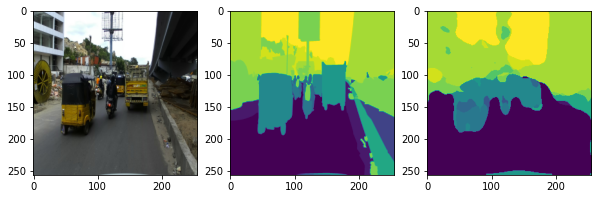

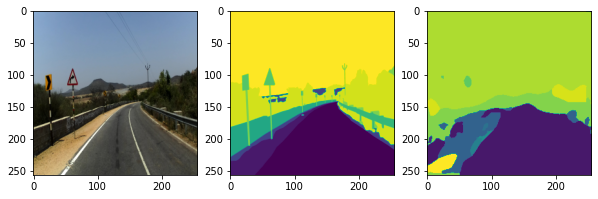

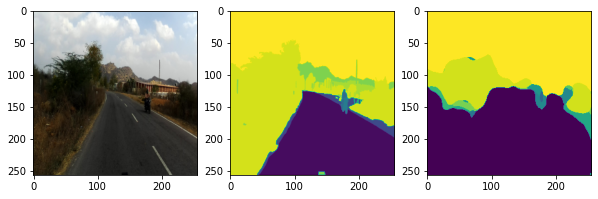

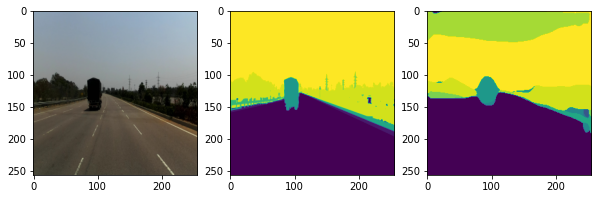

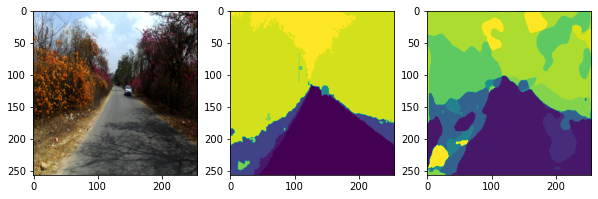

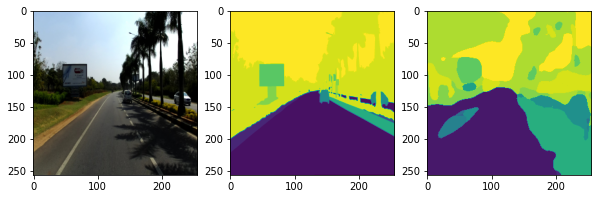

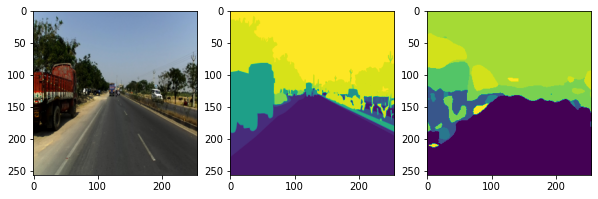

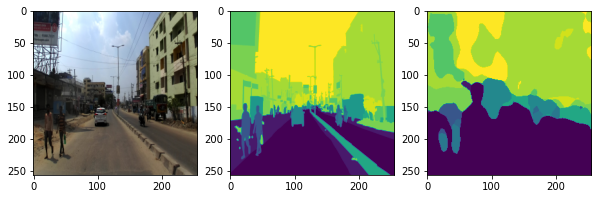

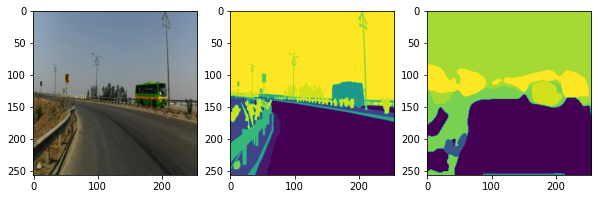

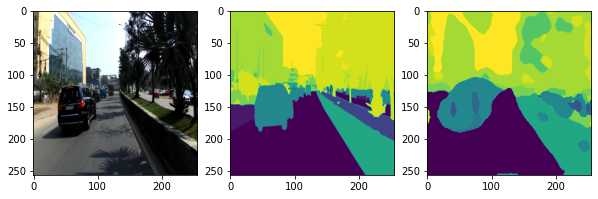

In [87]:
images_ = X_test['images'].values
masks_ = X_test['mask'].values
lst = np.arange(len(images_))
import random
ids = np.random.choice(lst, size = 15, replace = False)
for i in ids:
    image = cv2.imread(images_[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256, 256),  interpolation = cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, axis=0)

    mask  = cv2.imread(masks_[i], cv2.IMREAD_UNCHANGED)
    mask = cv2.resize(mask, (256, 256),  interpolation = cv2.INTER_AREA)
    mask = mask / 10
    pred = model.predict(image,verbose=1)
    pred = tf.argmax(pred, axis=-1)

    fig = plt.figure(figsize=(10,6))
  #plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(131)
    ax1.imshow(image[0,:,:])
    ax2=fig.add_subplot(132)
    ax2.imshow(mask)
    ax3=fig.add_subplot(133)
    ax3.imshow(pred[0,:,:])
    ax1.title.set_text('Image')
    ax2.title.set_text('Original Mask')
    ax3.title.set_text('Predicted Mask')
    plt.show()

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations